In [92]:
import pickle
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
os.environ['DGLBACKEND'] = 'pytorch'
from dgl import DGLGraph
import numpy as np
import scipy.sparse as spp
from scipy import spatial
from dgl.data import DGLDataset
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from ApolloScape_Dataset import ApolloScape_DGLDataset


In [93]:
train_dataset = ApolloScape_DGLDataset(train_val='train')
val_dataset = ApolloScape_DGLDataset(train_val='val')

In [131]:
# Collate function to prepare graphs
def collate_batch(samples):
    graphs, masks = map(list, zip(*samples))  # samples is a list of pairs (graph, mask) mask es VxTx1
    masks = torch.tensor(masks)
    masks= masks.view(masks.shape[0]*masks.shape[1],masks.shape[2],masks.shape[3])#.squeeze(0)
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).sqrt()  # graph size normalization 
    sizes_e = [graph.number_of_edges() for graph in graphs] # nb of edges
    snorm_e = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph.to(dev), masks.to(dev), snorm_n, snorm_e

In [132]:
train_dataloader=DataLoader(train_dataset, batch_size=5, shuffle=False, collate_fn=collate_batch)
val_dataloader=DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=collate_batch)


In [5]:
with open('../DBU_Graph/data/apollo_train_data.pkl', 'rb') as reader:
    [feat,adj, mean]=pickle.load(reader)
    
feat=np.transpose(feat, (0,3,2,1))
print(adj.shape)

(5010, 120, 120)


In [10]:
'''
#pruebas def preprocess_data de main.py (GRIP) 
feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
vel_data = feat[:,feature_id]  # N,C,T,V
vel_mask = (vel_data[:, :2, 1:]!=0) * (vel_data[:, :2, :-1]!=0) #False-> frames en los que no tenemos VELOCIDAD del obj
vel_data[:, :2, 1:] = (vel_data[:, :2, 1:] - vel_data[:, :2, :-1]).astype(float) * vel_mask.astype(float)
vel_data[:, :2, 0] = 0
print(vel_data[0,:,6:,0])
#print(new_mask[0,:,:,0])
'''


[[ 1.  1. -0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 6.  7.  8.  9. 10. 11.]
 [ 6.  7.  8.  9. 10.  0.]]


In [6]:

last_vis_obj=[]   #contains number of visible obj in each sequence of the training

for idx in range(len(adj)): 
    for i in range(len(adj[idx])): 
        if adj[idx][i,i] == 0:
            last_vis_obj.append(i)
            break   
            
last_vis_obj


[13,
 14,
 15,
 15,
 17,
 23,
 24,
 25,
 24,
 25,
 22,
 21,
 21,
 24,
 24,
 27,
 25,
 24,
 25,
 25,
 28,
 29,
 31,
 32,
 32,
 31,
 46,
 44,
 41,
 42,
 43,
 42,
 41,
 39,
 36,
 33,
 29,
 27,
 20,
 17,
 16,
 15,
 14,
 16,
 15,
 15,
 14,
 18,
 16,
 15,
 16,
 18,
 17,
 18,
 18,
 19,
 18,
 17,
 17,
 18,
 19,
 20,
 21,
 20,
 20,
 19,
 17,
 16,
 15,
 14,
 15,
 20,
 20,
 20,
 22,
 21,
 21,
 22,
 21,
 20,
 20,
 22,
 22,
 20,
 21,
 19,
 20,
 22,
 21,
 20,
 17,
 17,
 15,
 16,
 16,
 15,
 19,
 19,
 17,
 18,
 18,
 18,
 18,
 18,
 20,
 20,
 17,
 19,
 18,
 10,
 10,
 7,
 5,
 5,
 5,
 5,
 7,
 7,
 7,
 11,
 12,
 12,
 16,
 16,
 14,
 15,
 18,
 19,
 19,
 20,
 22,
 20,
 20,
 21,
 22,
 20,
 22,
 21,
 19,
 16,
 14,
 13,
 15,
 15,
 17,
 18,
 20,
 18,
 19,
 25,
 24,
 24,
 28,
 26,
 24,
 22,
 22,
 20,
 19,
 17,
 14,
 13,
 13,
 13,
 11,
 10,
 8,
 6,
 5,
 4,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 4,
 3,
 2,
 7,
 12,
 13,
 16,
 17,
 17,
 17,
 15,
 15,
 12,
 12,
 12,
 13,
 12,
 12,
 13,
 13,
 13,
 14,
 14,
 13,
 13,
 14,
 11,
 12

In [7]:
features=torch.from_numpy(feat[:,:70,:,:]).type(torch.float32)
print(features.shape)


torch.Size([5010, 70, 12, 11])


(tensor([ 0,  0,  1,  1,  2,  2,  2,  2,  3,  4,  5,  5,  5,  5,  5,  6,  6,  7,
         7,  7,  7,  7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 12,
        12, 12, 12]), tensor([ 0,  6,  1,  2,  1,  2,  8,  9,  3,  4,  5,  7,  9, 11, 12,  0,  6,  5,
         7, 10, 11, 12,  2,  8,  9,  2,  5,  8,  9,  7, 10,  5,  7, 11, 12,  5,
         7, 11, 12]))


<IPython.core.display.Javascript object>


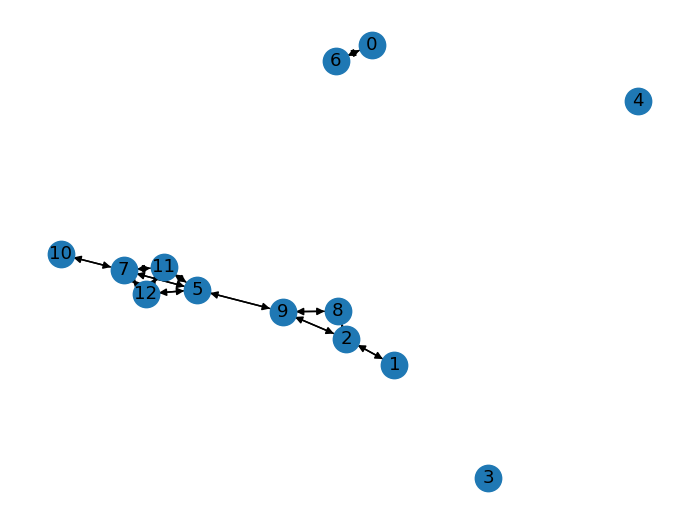

In [10]:
%matplotlib notebook
graph=dgl.DGLGraph(spp.coo_matrix(adj[0][:13,:13]))
print(graph.edges())
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

<IPython.core.display.Javascript object>


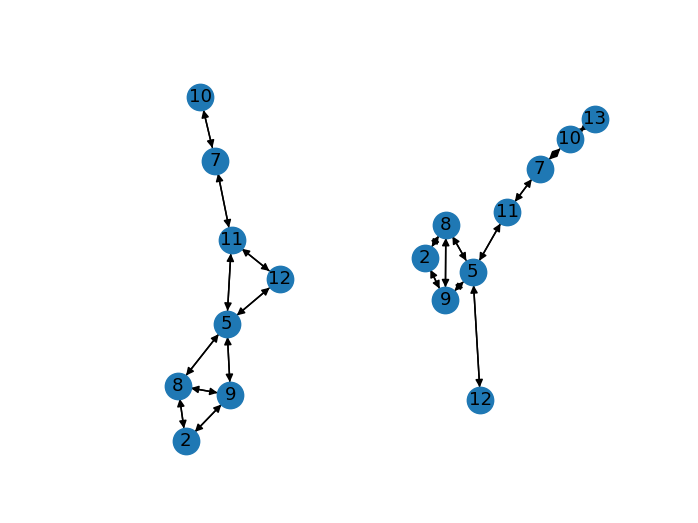

In [12]:
%matplotlib notebook

plt.subplot(1,2,1)
graph=dgl.DGLGraph(spp.coo_matrix(adj[1][:last_vis_obj[1],:last_vis_obj[1]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.subplot(1,2,2)
graph=dgl.DGLGraph(spp.coo_matrix(adj[2][:last_vis_obj[2],:last_vis_obj[2]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

### PREPROCESS DATA

### Crear grafo (Ejemplo secuencia 0)
Para el entrenamiento iterar sobre todas las secuencias

In [8]:
now_history_frame=6
object_type = features[:,:,:,2].int()  # torch Tensor NxVxT
#vis_obj_type=np.zeros((features.shape[0],features.shape[1])) #NxV
mask_car=np.zeros((features.shape[0],features.shape[1],now_history_frame)) #NxVx6
for i in range(len(features)):
    #vis_obj_type[i,:] =object_type[i,:,5] #Append Vx1 #tipos de obj visibles de la primera seq    
    mask_car_t=np.array([1  if (j==2 or j==1) else 0 for j in object_type[i,:,5]])  #1 si obj 1/2 en frame 5 (size V)
    mask_car[i,:]=np.array(mask_car_t).reshape(mask_car.shape[1],1)+np.zeros(6) #Vx6 mask para los 6 output frames que indican si el obj es visible y car

#COMPROBADO OK

In [9]:

feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
#120 agentes (13 visibles -> feat[11]=1) y 12 frames (si no hay info en alguno de os 12 frames: fila nula)
node_features = features[:,:,:now_history_frame,feature_id]  #obj type,x,y 6 primeros frames
node_labels=features[:,:,now_history_frame:,3:5] #x,y 6 ultimos frames
node_features[:,:,:,-1] *= mask_car   #Pongo 0 en feat 11 [mask] a todos los obj visibles no-car
node_labels[:,:,:,-1] *= mask_car
output_mask= features[:,:,6:,-1]*mask_car #mascara obj (car) visibles en 6º frame (5010,120,6)
output_mask.unsqueeze_(-1).type(torch.uint8)    #N,V,T,1                  

print(node_features.shape, node_labels.shape,output_mask.shape)

torch.Size([5010, 70, 6, 4]) torch.Size([5010, 70, 6, 2]) torch.Size([5010, 70, 6, 1])


In [10]:
zero_indeces_list = [i for i in range(len(output_mask)) if np.all(np.array(output_mask.squeeze(-1))==0, axis=(1,2))[i] == True ]
zero_indeces_list

[51,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 288,
 289,
 290,
 298,
 299,
 300,
 301,
 311,
 312,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 363,
 364,
 365,
 366,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1221,
 1222,
 1223,
 1224,
 1225,
 1226,
 1227,
 1231,
 1232,
 1233,
 1244,
 1245,
 1246,
 1247,
 1248,
 1249,
 1270,
 1

In [11]:
zero_maskcar_list = [i for i in range(len(mask_car)) if np.all(np.array(mask_car)==0, axis=(1,2))[i] == True ]
len(zero_maskcar_list) #374

374

In [12]:
total_num = len(features)
id_list = list(set(list(range(total_num))) - set(zero_indeces_list))
total_valid_num = len(id_list) #4596
ind=np.random.permutation(id_list)
train_id_list, val_id_list = ind[:round(total_valid_num*0.8)], ind[round(total_valid_num*0.8):]


'''
train_id_list = list(np.linspace(0, total_valid_num-1, int(total_valid_num*0.8)).astype(int))
val_id_list = list(set(list(range(total_valid_num))) - set(train_id_list))  

if train_val_test.lower() == 'train':
    self.all_feature = self.all_feature[train_id_list]
    self.all_adjacency = self.all_adjacency[train_id_list]
    self.all_mean_xy = self.all_mean_xy[train_id_list]
elif train_val_test.lower() == 'val':
    self.all_feature = self.all_feature[val_id_list]
    self.all_adjacency = self.all_adjacency[val_id_list]
    self.all_mean_xy = self.all_mean_xy[val_id_list]
'''
print(len(train_id_list)) #3677

3677


In [13]:
xy_dist=[spatial.distance.cdist(node_features[i][:,5,:], node_features[i][:,5,:]) for i in range(len(features))]  #5010x120x120

In [11]:
####PESOS EN EDGES
#120x120 -> solo quiero los que tengan 1 en Adj[0] (máscara) aka 39 valores
#Obtener las 39 distancias correspondientes a cada edge
distances = [xy_dist[0][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
print(len(distances))
norm_distances = [(i-min(distances))/(max(distances)-min(distances)) for i in distances]
norm_distances = [1/(i) if i!=0 else 1 for i in distances]
print(norm_distances)
#NORMALIZAR ENTRE 0 Y 1
graph.edata['w']=torch.tensor(norm_distances, dtype=torch.float32)

NameError: name 'graph' is not defined

### Convolutional Layer 

In [14]:
import dgl.function as fn
#Perform message passing and then apply fc Layer (self-loops! - same W for neighbors and itself)
# Traditional GCN:
#fn.copy_src(src='h', out='m')
#gcn_reduce = fn.sum(msg='m', out='h')
# multiply source node features with edge weights and aggregate them in destination nodes
gcn_msg=fn.u_mul_e('h', 'w', 'm') #elemnt-wise (broadcast)
gcn_reduce = fn.sum(msg='m', out='h')
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear = nn.Linear(in_feats, out_feats)
        
    def reduce_func(self, nodes):
        h = torch.sum(nodes.mailbox['m'], dim=1)
        return {'h': h}

    def forward(self, g, feature,e_w, snorm_n, snorm_e):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            
            g.ndata['h_s']=self.linear_self(feature)
            
            #normalization
            degs = g.out_degrees().float().clamp(min=1)
            norm=torch.pow(degs,-0.5)
            shp = norm.shape + (1,)*(feature.dim() -1)
            norm = torch.reshape(norm,shp)
            feature = feature*norm
            
            #aggregate
            g.edata['w'] = e_w
            g.ndata['h'] = feature
            g.update_all(gcn_msg, self.reduce_func)
            
            #mult W and normalization
            h = self.linear(g.ndata['h'])
            degs = g.in_degrees().float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feature.dim() - 1)
            norm = torch.reshape(norm, shp)
            h = h * norm
            
            h = g.ndata['h_s'] + h #Vx6xout_feats
            
            #h = h * (torch.ones_like(h)*snorm_n)  # normalize activation w.r.t. graph node size
            #e_w =  e_w * (torch.ones_like(e_w)*snorm_e)  # normalize activation w.r.t. graph edge size
            e_w =  e_w
            
            return h, e_w

In [16]:
#Prueba forward pass en gcn con un grafo OK
#model = GCN(in_feats=4, hid_feats=64, out_feats=2)
#model(graph, graph.ndata['x'],graph.edata['w'])

In [29]:
from dgl.nn import GatedGraphConv, GraphConv, GATConv,SAGEConv

conv = GraphConv(4,2, weight=True, bias=True)
#sageconv = SAGEConv(4,2,aggregator_type='lstm')
#gated_conv = GatedGraphConv(4, 2, 2, 3)
#gatconv=GATConv(4,2,num_heads=4)
graph = dgl.add_self_loop(graph)   #Añado selfloops pq no puede haber zero in-degree nodes
res = conv(graph, node_features[0])
print(res.shape)

torch.Size([70, 6, 2])


### Graph Convolutional Model

In [15]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = GCNLayer(in_feats=in_feats, out_feats=hid_feats)
        self.conv2 = GCNLayer(in_feats=hid_feats, out_feats=out_feats)
        self.fc= nn.Linear(out_feats,out_feats)
    def forward(self, graph, inputs,e_w,snorm_n, snorm_e):
        #inputs are features of nodes
        h,e_w = self.conv1(graph, inputs,e_w,snorm_n, snorm_e) #Vx6x4 -> Vx6x32  
        h = F.relu(h)
        h,_ = self.conv2(graph,h,e_w,snorm_n, snorm_e)  #Vx6x2  
        y = self.fc(h)
        return y
        

### GAT Layer

In [16]:
class My_GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GATLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear_func = nn.Linear(in_feats, out_feats, bias=False)
        self.attention_func = nn.Linear(2 * out_feats, 1, bias=False)
        
    def edge_attention(self, edges):
        concat_z = torch.cat([edges.src['z'], edges.dst['z']], dim=1).sum(dim=0) #(6,2)||(6,2) -> (6,4) -> (4)
        src_e = self.attention_func(concat_z)  #(1) att logit
        src_e = F.leaky_relu(src_e)
        return {'e': src_e}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e':edges.data['e']}
        
    def reduce_func(self, nodes):
        h_s = nodes.data['h_s']
        a = F.softmax(nodes.mailbox['e'], dim=1)   #attention score between nodes i and j
        h = h_s + torch.sum(a * nodes.mailbox['z'], dim=1)
        return {'h': h}
                               
    def forward(self, graph, h):
        h_in = h
        g.ndata['h']  = h 
        g.ndata['h_s'] = self.linear_self(h) 
        g.ndata['z'] = self.linear_func(h) #(6,4) -> (6,2) infeats=4 outfeats=2
        graph.apply_edges(self.edge_attention)
        graph.update_all(self.message_func, self.reduce_func)
        h = g.ndata['h'] # result of graph convolution
        #h = h * snorm_n # normalize activation w.r.t. graph node size
        #h = self.bn_node_h(h) # batch normalization 
        h = torch.relu(h) # non-linear activation
        h = h_in + h # residual connection
        return h #graph.ndata.pop('h')


class MultiHeadGATLayer(nn.Module):
    def __init__(self, in_feats, out_feats, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(My_GATLayer(in_dim, out_dim))
        self.merge = merge

    def forward(self, g, h):
        head_outs = [attn_head(g, h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1), for intermediate layers
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average, for final layer
            return torch.mean(torch.stack(head_outs))

In [ ]:
class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, input_dim) 
        self.layer2 = nn.Linear(input_dim, output_dim) 
        
    def forward(self, x):
        y = x
        y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

In [17]:
class My_GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.gat_1 = GATLayer(hidden_dim, hidden_dim)
        self.gat_2 = GATLayer(hidden_dim, hidden_dim)
        #self.gat_1 = MultiHeadGATLayer(hidden_dim, hidden_dim, heads)
        #self.gat_2 = MultiHeadGATLayer(hidden_dim*heads, hidden_dim, 1)
        self.linear1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)  #input (6,4) - (6,32)
        
        # gat layers
        h = F.relu(self.gat_1(g, h))
        h = F.relu(self.gat_2(g, h))
        
        y = self.linear1(h)  # (6,32) -> (6,2)
        
        return y

### TRAINING Tests

#### Collate function to prepare graphs

In [18]:
def compute_RMSE(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  (70,6,1)
    pred = pred*mask #Con esto ya quito del error aquellas filas donde no tengo datos.
    gt = gt*mask  #120 nodos outputmask V,T,C
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=2) #V,T 
    overall_sum_time = x2y2_error.sum(dim=0).requires_grad_()  #T - suma de los errores de los V agentes
    overall_num = mask.sum(dim=-1).sum(dim=0).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame
    return overall_sum_time, overall_num, x2y2_error



In [19]:
def compute_RMSE_batch(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  (B*)V,T,1
    pred = pred*mask #B*V,T,C  (B n grafos en el batch)
    gt = gt*mask  # outputmask BV,T,C
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) #BV,T 
    overall_sum_time = x2y2_error.sum(dim=-2)  #B,T - suma de los errores de los V agentes
    overall_num = mask.sum(dim=-1).sum(dim=-2).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame
    return overall_sum_time, overall_num, x2y2_error



In [42]:
from tqdm import tqdm

dev = 'cuda'
model = GCN(in_feats=4, hid_feats=32, out_feats=2).to(dev)
#model = My_GAT(input_dim=4, hidden_dim=64, output_dim=2)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
def err_handler(type, flag):
    print("Floating point error (%s), with flag %s,iter %d" % (type, flag, i))
np.seterrcall(err_handler)
np.seterr(all='raise')
for epoch in range(20):
    print('Epoch: ',epoch)
    overall_loss_train=[]
    overall_loss_val=[]
    model.train()
    for i in tqdm(train_id_list):
        graph = dgl.from_scipy(spp.coo_matrix(adj[i][:last_vis_obj[i],:last_vis_obj[i]])).int().to(dev)
        snorm_n, snorm_e, norm_d = collate(graph)
        #graph = dgl.remove_self_loop(graph)
        #graph = dgl.add_self_loop(graph)
        distances = [xy_dist[i][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
        norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
        norm_distances = [1/(i) if i!=0 else 1 for i in distances]
        e_w=torch.tensor(norm_distances, dtype=torch.float32).to(dev)
        #forward prop by using all nodes
        pred = model(graph, node_features[i,:last_vis_obj[i]].to(dev),e_w,snorm_n, snorm_e)  #pred 120x6x2 , output mask 120x6x1
        #compute loss
        overall_sum_time, overall_num, _ = compute_RMSE(pred, node_labels[i,:last_vis_obj[i]].to(dev), output_mask[i,:last_vis_obj[i]].to(dev))
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num)#torch.max(torch.sum(overall_num).type(torch.int), torch.ones(1,).type(torch.int).to(dev))    
        opt.zero_grad() 
        total_loss.backward()
        opt.step()
        overall_loss_train.extend([total_loss.detach().cpu().numpy().sum(axis=0)])
    #print('|{}| Train_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_train) + [np.sum(overall_loss_train)]])))
    print('|{}| Train_loss: {}, len:{}'.format(datetime.now(), np.sum(overall_loss_train), len(overall_loss_train)))

    model.eval()
    with torch.no_grad():
        for i in val_id_list:
            graph = dgl.from_scipy(spp.coo_matrix(adj[i][:last_vis_obj[i],:last_vis_obj[i]])).int().to(dev)
            snorm_n, snorm_e, norm_d = collate(graph)
            #graph = dgl.remove_self_loop(graph)
            #graph = dgl.add_self_loop(graph)
            distances = [xy_dist[i][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
            norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
            norm_distances = [1/(i) if i!=0 else 1 for i in distances]
            e_w=torch.tensor(norm_distances, dtype=torch.float32).to(dev)
            
            #forward prop by using all nodes
            pred = model(graph, node_features[i,:last_vis_obj[i]].to(dev),e_w,snorm_n, snorm_e)
            _, overall_num, x2y2_error = compute_RMSE(pred, node_labels[i,:last_vis_obj[i]].to(dev), output_mask[i,:last_vis_obj[i]].to(dev))
            x2y2_error=x2y2_error.detach().cpu().numpy().sum(axis=0)
            overall_sum_time = np.sum(x2y2_error**0.5, axis=0)  #suma del error de todos los agentes en los T frames
            overall_num_time = np.sum(overall_num.detach().cpu().numpy(), axis=0) #numero de agentes en los T frames
            overall_loss_val.extend([overall_sum_time / (overall_num_time)]) #media del error de cada agente en los T frames
            
    print('|{}| Val_loss: {}, len:{}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_val) + [np.sum(overall_loss_val)]]), len(overall_loss_val)))


  0%|          | 5/3677 [00:00<01:20, 45.72it/s]

Epoch:  0


100%|██████████| 3677/3677 [01:02<00:00, 58.47it/s]


|2020-11-10 08:26:11.657242| Train_loss: 2034776.9557352923, len:3677


IndexError: Replacement index 2 out of range for positional args tuple

In [21]:
# Collate function to prepare graphs
def collate(graph):
    snorm_n = (1 / graph.number_of_nodes())**0.5  # graph size normalization 
    snorm_e = (1 / graph.number_of_edges())**0.5 # graph size normalization
    norm_d = torch.pow(graph.in_degrees().float(),-0.5)
    norm_d[torch.isinf(norm_d)]=0  #size [n_nodes]
    return snorm_n, snorm_e, norm_d

In [134]:
from tqdm import tqdm

dev='cuda'
model = GCN(in_feats=4, hid_feats=32, out_feats=2).to(dev)
#model = My_GAT(input_dim=4, hidden_dim=64, output_dim=2)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
np.seterr(all='raise')
train_loss_sum=[]
val_loss_sum=[]
for epoch in range(20):
    print('Epoch: ',epoch)
    overall_loss_train=[]
    overall_loss_val=[]
    model.train()
    overall_loss_train=[]
    overall_loss_val=[]    
    for batched_graph, output_masks,snorm_n, snorm_e in tqdm(train_dataloader):
        feats = batched_graph.ndata['x'].float().to(dev)
        e_w = batched_graph.edata['w'].float().to(dev)
        labels= batched_graph.ndata['gt'].float().to(dev)
        pred = model(batched_graph, feats,e_w,snorm_n,snorm_e)   #70,6,2
        
        overall_sum_time, overall_num, _ = compute_RMSE_batch(pred, labels, output_masks)  #(B,6)
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num) #valores similares
        opt.zero_grad() 
        total_loss.backward()
        opt.step()
        overall_loss_train.extend([total_loss.detach().cpu().numpy().sum(axis=0)])
       
    #print('|{}| Train_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_train) + [np.sum(overall_loss_train)]])))
    print('|{}| Train_loss: {}, len: {}'.format(datetime.now(), np.sum(overall_loss_train),len(overall_loss_train)))
    train_loss_sum.extend(np.sum(overall_loss_train))
    model.eval()
    with torch.no_grad():
               
        for batched_graph, output_masks,snorm_n, snorm_e in tqdm(val_dataloader):
            feats = batched_graph.ndata['x'].float().to(dev)
            e_w = batched_graph.edata['w'].float().to(dev)
            labels= batched_graph.ndata['gt'].float().to(dev)
            pred = model(batched_graph, feats,e_w,snorm_n,snorm_e)
            _, overall_num, x2y2_error = compute_RMSE_batch(pred, labels, output_masks)
            #print(x2y2_error.shape)  1,70,2
            x2y2_error=x2y2_error.detach().cpu().numpy().sum(axis=0)  #BV,T -> T
            overall_sum_time = np.sum(x2y2_error**0.5, axis=0)  #suma del error de todos los agentes en los T frames
            overall_num_time = np.sum(overall_num.detach().cpu().numpy(), axis=0) #numero de agentes en los T frames
            overall_loss_val.extend([overall_sum_time / overall_num_time]) #media del error de cada agente en los T frames
            
    print('|{}| Val_loss: {}, len:{}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_val) + [np.sum(overall_loss_val)]]), len(overall_loss_val)))
    val_loss_sum.extend(np.sum(overall_loss_val))

  0%|          | 3/736 [00:00<00:29, 24.56it/s]

Epoch:  0


  3%|▎         | 5/184 [00:00<00:03, 48.27it/s]

|2020-11-10 09:27:47.894888| Train_loss: 936021.4900038678, len: 736


  1%|          | 4/736 [00:00<00:26, 27.65it/s]

|2020-11-10 09:27:53.644243| Val_loss: 4.122 4.909 7.005 3.723 5.105 4.116 4.468 7.961 4.888 4.483 4.741 5.101 4.148 6.621 4.271 4.192 3.799 5.581 7.097 6.916 5.175 3.453 4.319 5.703 5.070 8.918 9.739 4.224 4.248 3.784 5.614 3.943 4.776 4.217 5.309 5.060 3.983 5.844 2.935 4.435 5.974 6.857 5.084 3.800 4.055 3.755 3.852 4.021 7.534 6.335 4.031 5.027 7.779 6.253 5.628 5.480 4.797 3.452 4.888 5.048 3.151 4.780 6.008 7.648 5.100 4.030 5.131 5.856 3.491 2.496 4.890 4.995 2.936 113.349 3.764 3.421 3.226 3.913 10.216 4.528 2.999 6.507 2.645 5.372 5.822 3.369 4.591 6.258 3.779 3.074 3.755 6.558 4.444 3.976 3.307 4.775 4.903 6.672 2.714 4.834 5.628 10.309 3.788 9.037 5.164 4.731 6.335 3.440 4.072 4.900 3.887 5.882 8.313 3.356 4.552 4.940 3.438 5.019 11.169 5.330 3.467 4.482 5.195 3.407 5.630 3.966 5.233 4.224 5.257 6.642 6.005 7.162 6.979 5.260 6.796 4.573 3.146 3.993 4.801 5.664 3.370 5.461 4.001 3.369 6.627 4.110 2.770 3.733 5.017 2.681 5.107 4.335 3.938 4.738 3.071 5.647 4.510 5.922 6.369 8.

  3%|▎         | 5/184 [00:00<00:04, 39.47it/s]

|2020-11-10 09:28:20.769687| Train_loss: 496536.4854003873, len: 736


  1%|          | 4/736 [00:00<00:23, 31.19it/s]

|2020-11-10 09:28:27.117166| Val_loss: 4.062 4.825 6.933 3.721 5.041 4.024 4.468 7.927 4.888 4.474 4.740 5.076 4.127 6.466 4.205 4.105 3.759 5.508 7.096 6.881 5.136 3.356 4.261 5.697 5.081 8.912 9.700 4.209 4.185 3.763 5.475 3.875 4.709 4.252 5.327 5.037 3.927 5.819 2.904 4.431 5.898 6.764 5.013 3.711 4.003 3.650 3.799 3.917 7.465 6.289 3.990 4.967 7.784 6.196 5.582 5.450 4.761 3.421 4.894 4.949 3.124 4.744 5.984 6.130 5.103 3.981 5.130 5.274 3.488 2.498 4.864 4.971 2.891 78.130 3.745 3.380 3.194 3.871 10.217 4.482 2.935 6.445 2.565 5.352 5.783 3.332 4.521 6.259 3.673 3.053 3.707 6.539 4.279 3.924 3.268 4.741 4.886 6.701 2.597 4.753 5.578 10.265 3.623 9.013 5.159 4.694 6.362 3.357 4.054 4.823 3.911 5.823 8.248 3.364 4.477 4.874 3.434 4.961 11.166 5.352 3.408 4.390 5.185 3.303 5.561 3.838 5.233 4.031 5.256 6.630 5.879 7.061 6.885 5.182 6.729 4.455 3.119 3.906 4.778 5.617 3.282 5.437 4.017 3.355 6.600 3.979 2.702 3.669 4.946 2.609 5.076 4.330 3.850 4.658 3.060 5.628 4.469 5.894 6.315 8.2

  3%|▎         | 5/184 [00:00<00:04, 41.30it/s]

|2020-11-10 09:28:54.714887| Train_loss: 389416.70005264034, len: 736


  1%|          | 4/736 [00:00<00:19, 38.51it/s]

|2020-11-10 09:29:00.586541| Val_loss: 4.039 4.804 6.885 3.712 4.982 3.961 4.458 7.917 4.892 4.484 4.780 5.090 4.132 6.367 4.172 4.071 3.741 5.471 7.102 6.877 5.116 3.301 4.229 5.690 5.090 8.920 9.675 4.221 4.140 3.750 5.382 3.839 4.655 4.281 5.357 5.037 3.899 5.810 2.887 4.444 5.857 6.691 4.974 3.646 3.985 3.565 3.767 3.858 7.490 6.255 3.976 4.938 7.812 6.149 5.552 5.415 4.755 3.410 4.912 4.889 3.110 4.730 5.977 5.088 5.095 3.975 5.143 4.838 3.497 2.514 4.865 4.924 2.871 56.071 3.719 3.365 3.170 3.863 10.254 4.469 2.898 6.405 2.505 5.357 5.764 3.312 4.467 6.289 3.619 3.058 3.693 6.528 4.168 3.898 3.229 4.723 4.883 6.727 2.555 4.720 5.562 10.257 3.528 8.942 5.178 4.685 6.366 3.307 4.035 4.788 3.925 5.758 8.197 3.344 4.426 4.846 3.458 4.954 11.159 5.365 3.375 4.344 5.198 3.248 5.499 3.755 5.212 3.923 5.287 6.644 5.841 6.981 6.830 5.113 6.694 4.407 3.107 3.849 4.782 5.581 3.225 5.439 4.016 3.342 6.594 3.913 2.658 3.638 4.898 2.570 5.042 4.334 3.824 4.617 3.061 5.614 4.442 5.856 6.274 8.3

  3%|▎         | 5/184 [00:00<00:04, 42.00it/s]

|2020-11-10 09:29:28.417077| Train_loss: 384891.18055288575, len: 736


  1%|          | 5/736 [00:00<00:18, 38.63it/s]

|2020-11-10 09:29:34.436104| Val_loss: 4.012 4.799 6.845 3.702 4.951 3.941 4.447 7.885 4.898 4.484 4.821 5.113 4.140 6.332 4.158 4.050 3.720 5.440 7.120 6.890 5.111 3.296 4.242 5.693 5.068 8.890 9.671 4.220 4.103 3.766 5.320 3.831 4.642 4.298 5.348 5.050 3.901 5.833 2.881 4.449 5.861 6.688 4.942 3.630 3.979 3.530 3.735 3.846 7.486 6.267 3.961 4.902 7.796 6.119 5.541 5.442 4.749 3.442 4.908 4.854 3.113 4.759 5.973 4.527 5.081 3.968 5.143 4.692 3.500 2.513 4.854 4.897 2.871 53.741 3.722 3.364 3.146 3.858 10.297 4.471 2.881 6.379 2.490 5.345 5.762 3.330 4.449 6.284 3.591 3.094 3.681 6.548 4.093 3.868 3.215 4.712 4.898 6.655 2.553 4.715 5.533 10.251 3.493 8.944 5.193 4.680 6.431 3.308 4.033 4.777 3.926 5.705 8.218 3.330 4.403 4.843 3.456 4.948 11.212 5.395 3.361 4.314 5.185 3.217 5.488 3.718 5.198 3.872 5.286 6.616 5.868 6.916 6.796 5.060 6.718 4.380 3.092 3.823 4.785 5.580 3.204 5.425 4.030 3.366 6.590 3.897 2.640 3.625 4.871 2.553 5.037 4.327 3.824 4.611 3.070 5.616 4.434 5.835 6.268 8.3

  3%|▎         | 5/184 [00:00<00:04, 41.27it/s]

|2020-11-10 09:30:00.925208| Train_loss: 384628.7585382773, len: 736


  1%|          | 4/736 [00:00<00:18, 39.28it/s]

|2020-11-10 09:30:07.013076| Val_loss: 3.997 4.795 6.822 3.704 4.928 3.929 4.439 7.869 4.908 4.485 4.843 5.124 4.145 6.334 4.150 4.038 3.703 5.423 7.141 6.898 5.107 3.294 4.251 5.699 5.045 8.879 9.678 4.221 4.073 3.776 5.283 3.833 4.636 4.311 5.349 5.059 3.900 5.840 2.878 4.454 5.868 6.687 4.925 3.617 3.977 3.514 3.715 3.842 7.491 6.275 3.956 4.880 7.787 6.104 5.537 5.458 4.754 3.464 4.902 4.833 3.114 4.783 5.974 4.360 5.077 3.962 5.139 4.639 3.505 2.520 4.852 4.880 2.869 52.959 3.722 3.368 3.132 3.868 10.322 4.482 2.873 6.365 2.481 5.337 5.760 3.339 4.440 6.287 3.579 3.108 3.677 6.562 4.048 3.853 3.199 4.705 4.911 6.612 2.551 4.715 5.520 10.252 3.465 8.933 5.206 4.680 6.466 3.307 4.030 4.772 3.925 5.682 8.228 3.320 4.392 4.841 3.448 4.945 11.229 5.411 3.348 4.297 5.187 3.203 5.481 3.697 5.188 3.851 5.291 6.604 5.882 6.882 6.774 5.030 6.732 4.369 3.079 3.808 4.794 5.580 3.195 5.419 4.033 3.384 6.587 3.885 2.622 3.619 4.858 2.539 5.027 4.318 3.820 4.605 3.077 5.615 4.429 5.816 6.263 8.3

  3%|▎         | 5/184 [00:00<00:03, 45.03it/s]

|2020-11-10 09:30:33.398837| Train_loss: 387984.6072512724, len: 736


  1%|          | 4/736 [00:00<00:20, 36.48it/s]

|2020-11-10 09:30:39.151383| Val_loss: 3.990 4.784 6.808 3.707 4.912 3.925 4.433 7.858 4.920 4.488 4.850 5.128 4.151 6.340 4.145 4.031 3.692 5.418 7.154 6.898 5.106 3.297 4.254 5.702 5.023 8.878 9.682 4.220 4.049 3.780 5.263 3.835 4.633 4.318 5.351 5.064 3.898 5.846 2.880 4.457 5.874 6.681 4.914 3.609 3.979 3.508 3.700 3.839 7.506 6.282 3.956 4.867 7.781 6.103 5.531 5.463 4.765 3.475 4.898 4.821 3.110 4.797 5.977 4.372 5.072 3.964 5.134 4.614 3.509 2.530 4.856 4.869 2.869 47.215 3.724 3.372 3.125 3.880 10.334 4.492 2.871 6.358 2.477 5.331 5.759 3.339 4.433 6.288 3.576 3.110 3.677 6.569 4.017 3.844 3.183 4.700 4.921 6.591 2.552 4.717 5.513 10.259 3.452 8.914 5.209 4.681 6.477 3.305 4.026 4.769 3.921 5.673 8.240 3.319 4.388 4.837 3.438 4.945 11.222 5.419 3.337 4.284 5.194 3.198 5.473 3.688 5.180 3.842 5.297 6.598 5.894 6.865 6.760 5.018 6.743 4.369 3.069 3.800 4.807 5.579 3.193 5.414 4.036 3.395 6.588 3.876 2.604 3.617 4.850 2.531 5.021 4.309 3.818 4.600 3.080 5.617 4.429 5.803 6.262 8.3

  3%|▎         | 5/184 [00:00<00:04, 40.05it/s]

|2020-11-10 09:31:05.465987| Train_loss: 390762.1381694233, len: 736


  1%|          | 4/736 [00:00<00:20, 36.26it/s]

|2020-11-10 09:31:11.757392| Val_loss: 3.983 4.778 6.795 3.717 4.899 3.917 4.435 7.849 4.931 4.479 4.844 5.117 4.154 6.341 4.134 4.030 3.681 5.414 7.166 6.899 5.103 3.296 4.248 5.705 5.002 8.883 9.678 4.218 4.023 3.780 5.241 3.830 4.622 4.320 5.362 5.067 3.896 5.852 2.877 4.455 5.875 6.668 4.902 3.596 3.980 3.503 3.687 3.832 7.527 6.282 3.958 4.856 7.772 6.101 5.526 5.460 4.776 3.470 4.897 4.803 3.105 4.805 5.977 4.414 5.067 3.973 5.132 4.595 3.516 2.538 4.859 4.850 2.864 38.403 3.724 3.372 3.128 3.894 10.321 4.492 2.867 6.339 2.470 5.330 5.760 3.327 4.425 6.291 3.574 3.103 3.675 6.567 3.987 3.834 3.171 4.691 4.927 6.584 2.544 4.720 5.508 10.265 3.434 8.878 5.206 4.679 6.474 3.300 4.019 4.774 3.911 5.666 8.248 3.322 4.381 4.832 3.422 4.944 11.215 5.426 3.327 4.272 5.202 3.204 5.458 3.676 5.178 3.836 5.303 6.588 5.902 6.858 6.745 5.011 6.746 4.367 3.058 3.797 4.813 5.573 3.189 5.403 4.020 3.398 6.590 3.855 2.590 3.616 4.840 2.524 5.016 4.302 3.816 4.598 3.073 5.618 4.423 5.789 6.259 8.2

  3%|▎         | 5/184 [00:00<00:04, 40.72it/s]

|2020-11-10 09:31:38.844681| Train_loss: 384508.03310719645, len: 736


  1%|          | 4/736 [00:00<00:20, 36.58it/s]

|2020-11-10 09:31:44.647116| Val_loss: 3.973 4.771 6.782 3.717 4.892 3.910 4.438 7.836 4.937 4.469 4.837 5.113 4.160 6.338 4.127 4.029 3.674 5.413 7.167 6.894 5.102 3.299 4.249 5.704 4.997 8.881 9.673 4.213 4.004 3.782 5.223 3.825 4.614 4.322 5.363 5.069 3.895 5.867 2.878 4.450 5.874 6.648 4.886 3.589 3.982 3.496 3.679 3.825 7.551 6.288 3.957 4.844 7.761 6.101 5.521 5.459 4.783 3.464 4.899 4.789 3.102 4.813 5.977 4.437 5.060 3.981 5.130 4.584 3.519 2.542 4.859 4.836 2.863 32.930 3.725 3.368 3.131 3.900 10.314 4.490 2.864 6.321 2.465 5.326 5.764 3.319 4.417 6.289 3.575 3.103 3.670 6.571 3.957 3.823 3.161 4.687 4.933 6.572 2.544 4.729 5.500 10.271 3.428 8.853 5.203 4.676 6.479 3.300 4.011 4.780 3.903 5.655 8.252 3.323 4.380 4.826 3.413 4.945 11.219 5.438 3.319 4.260 5.201 3.206 5.447 3.669 5.175 3.828 5.306 6.572 5.919 6.850 6.734 5.005 6.756 4.366 3.048 3.798 4.814 5.568 3.185 5.387 4.016 3.400 6.595 3.842 2.579 3.615 4.825 2.523 5.016 4.299 3.821 4.596 3.069 5.624 4.420 5.781 6.253 8.2

  3%|▎         | 5/184 [00:00<00:04, 44.40it/s]

|2020-11-10 09:32:11.248371| Train_loss: 386369.42967174586, len: 736


  1%|          | 4/736 [00:00<00:18, 38.77it/s]

|2020-11-10 09:32:17.005358| Val_loss: 3.964 4.765 6.767 3.720 4.884 3.897 4.442 7.824 4.943 4.455 4.830 5.106 4.166 6.331 4.120 4.031 3.666 5.410 7.173 6.891 5.099 3.299 4.243 5.702 4.988 8.884 9.668 4.207 3.983 3.782 5.203 3.817 4.597 4.326 5.368 5.073 3.895 5.882 2.876 4.444 5.868 6.624 4.872 3.577 3.984 3.488 3.671 3.816 7.579 6.290 3.957 4.834 7.755 6.098 5.524 5.452 4.791 3.457 4.900 4.772 3.100 4.818 5.974 4.471 5.051 3.993 5.131 4.570 3.524 2.544 4.858 4.814 2.860 31.595 3.724 3.364 3.133 3.906 10.303 4.486 2.861 6.296 2.455 5.325 5.767 3.312 4.407 6.289 3.574 3.100 3.663 6.571 3.929 3.811 3.153 4.684 4.943 6.568 2.543 4.735 5.494 10.277 3.419 8.816 5.207 4.673 6.475 3.298 4.001 4.784 3.895 5.650 8.252 3.324 4.378 4.822 3.404 4.945 11.210 5.448 3.311 4.249 5.200 3.212 5.433 3.660 5.172 3.827 5.309 6.561 5.936 6.846 6.724 5.001 6.759 4.365 3.039 3.799 4.813 5.559 3.179 5.380 4.006 3.397 6.599 3.829 2.570 3.614 4.808 2.521 5.015 4.297 3.826 4.596 3.065 5.628 4.413 5.767 6.245 8.2

  3%|▎         | 5/184 [00:00<00:04, 38.75it/s]

|2020-11-10 09:32:43.185938| Train_loss: 382075.0359988829, len: 736


  1%|          | 4/736 [00:00<00:21, 34.19it/s]

|2020-11-10 09:32:49.182483| Val_loss: 3.954 4.757 6.755 3.724 4.883 3.888 4.446 7.809 4.950 4.449 4.820 5.111 4.175 6.323 4.112 4.033 3.659 5.405 7.173 6.880 5.098 3.298 4.241 5.703 4.984 8.879 9.659 4.199 3.966 3.784 5.183 3.808 4.590 4.327 5.370 5.074 3.895 5.899 2.876 4.434 5.866 6.606 4.856 3.573 3.985 3.483 3.663 3.807 7.603 6.299 3.956 4.821 7.744 6.091 5.517 5.452 4.797 3.452 4.902 4.754 3.101 4.826 5.970 4.531 5.043 4.004 5.130 4.565 3.526 2.544 4.856 4.797 2.861 28.317 3.726 3.357 3.138 3.910 10.303 4.479 2.858 6.274 2.450 5.325 5.769 3.308 4.397 6.284 3.573 3.097 3.655 6.574 3.901 3.799 3.146 4.684 4.948 6.554 2.540 4.744 5.489 10.281 3.416 8.790 5.211 4.667 6.475 3.297 3.995 4.787 3.889 5.642 8.259 3.326 4.375 4.818 3.385 4.945 11.201 5.460 3.301 4.241 5.198 3.219 5.423 3.662 5.174 3.822 5.311 6.546 5.953 6.846 6.714 5.001 6.765 4.360 3.032 3.802 4.811 5.551 3.173 5.368 4.003 3.398 6.606 3.814 2.566 3.613 4.791 2.519 5.017 4.294 3.833 4.592 3.060 5.633 4.411 5.758 6.236 8.2

  3%|▎         | 5/184 [00:00<00:04, 38.99it/s]

|2020-11-10 09:33:15.636580| Train_loss: 378456.1349320759, len: 736


  1%|          | 4/736 [00:00<00:19, 36.86it/s]

|2020-11-10 09:33:21.384979| Val_loss: 3.946 4.759 6.740 3.722 4.876 3.875 4.449 7.803 4.957 4.439 4.819 5.103 4.181 6.303 4.106 4.037 3.655 5.399 7.171 6.871 5.096 3.298 4.243 5.701 4.990 8.876 9.649 4.192 3.956 3.782 5.162 3.794 4.578 4.329 5.376 5.075 3.893 5.915 2.871 4.431 5.861 6.587 4.841 3.562 3.986 3.468 3.660 3.796 7.629 6.294 3.955 4.812 7.736 6.081 5.514 5.443 4.799 3.439 4.906 4.734 3.099 4.830 5.966 4.333 5.037 4.016 5.129 4.536 3.531 2.545 4.855 4.778 2.860 31.954 3.723 3.355 3.141 3.911 10.292 4.471 2.855 6.259 2.436 5.326 5.770 3.297 4.383 6.291 3.569 3.098 3.647 6.573 3.873 3.789 3.140 4.681 4.953 6.544 2.533 4.753 5.486 10.283 3.413 8.757 5.211 4.667 6.470 3.295 3.988 4.799 3.881 5.622 8.250 3.326 4.372 4.815 3.382 4.950 11.208 5.468 3.297 4.234 5.194 3.215 5.408 3.649 5.174 3.810 5.317 6.535 5.966 6.842 6.704 4.997 6.764 4.357 3.027 3.797 4.812 5.541 3.162 5.358 3.993 3.394 6.612 3.796 2.563 3.609 4.775 2.518 5.013 4.294 3.837 4.587 3.053 5.634 4.410 5.748 6.220 8.1

  3%|▎         | 5/184 [00:00<00:04, 44.14it/s]

|2020-11-10 09:33:49.045147| Train_loss: 380361.4155567789, len: 736


  1%|          | 5/736 [00:00<00:18, 39.59it/s]

|2020-11-10 09:33:54.545086| Val_loss: 3.938 4.751 6.722 3.732 4.873 3.863 4.453 7.789 4.956 4.430 4.815 5.125 4.188 6.305 4.108 4.031 3.646 5.395 7.190 6.866 5.092 3.306 4.231 5.701 4.973 8.871 9.651 4.191 3.939 3.788 5.142 3.793 4.564 4.339 5.382 5.080 3.893 5.935 2.876 4.416 5.854 6.574 4.832 3.556 3.989 3.468 3.655 3.792 7.637 6.307 3.954 4.800 7.744 6.073 5.520 5.451 4.806 3.445 4.902 4.722 3.108 4.839 5.958 4.679 5.026 4.029 5.128 4.544 3.537 2.546 4.847 4.763 2.858 37.401 3.716 3.353 3.142 3.907 10.321 4.471 2.853 6.241 2.434 5.328 5.770 3.305 4.372 6.287 3.567 3.094 3.639 6.583 3.859 3.779 3.134 4.686 4.960 6.543 2.540 4.751 5.483 10.281 3.411 8.740 5.241 4.664 6.477 3.296 3.985 4.784 3.888 5.641 8.247 3.318 4.373 4.811 3.372 4.945 11.156 5.483 3.290 4.230 5.191 3.227 5.405 3.658 5.175 3.829 5.320 6.535 5.978 6.843 6.699 4.991 6.766 4.350 3.021 3.807 4.808 5.533 3.162 5.365 3.985 3.395 6.615 3.802 2.563 3.606 4.759 2.515 5.020 4.287 3.843 4.585 3.053 5.639 4.402 5.739 6.208 8.1

  3%|▎         | 5/184 [00:00<00:03, 45.09it/s]

|2020-11-10 09:34:19.259346| Train_loss: 380941.32544420974, len: 736


  1%|          | 5/736 [00:00<00:18, 38.61it/s]

|2020-11-10 09:34:24.793587| Val_loss: 3.931 4.767 6.713 3.730 4.877 3.852 4.461 7.795 4.960 4.414 4.809 5.082 4.185 6.277 4.094 4.039 3.647 5.385 7.179 6.859 5.087 3.300 4.243 5.701 4.993 8.868 9.623 4.185 3.937 3.784 5.123 3.772 4.564 4.334 5.386 5.077 3.893 5.946 2.860 4.417 5.845 6.560 4.820 3.548 3.985 3.452 3.660 3.779 7.650 6.289 3.952 4.796 7.726 6.063 5.512 5.447 4.799 3.413 4.913 4.698 3.101 4.840 5.950 4.237 5.029 4.037 5.131 4.518 3.541 2.539 4.844 4.755 2.856 35.954 3.713 3.352 3.158 3.903 10.276 4.454 2.847 6.239 2.417 5.333 5.769 3.283 4.360 6.300 3.562 3.090 3.629 6.570 3.843 3.772 3.139 4.680 4.954 6.538 2.515 4.756 5.485 10.277 3.413 8.716 5.213 4.661 6.466 3.293 3.980 4.814 3.873 5.610 8.225 3.320 4.370 4.805 3.366 4.951 11.201 5.487 3.293 4.225 5.183 3.227 5.388 3.637 5.180 3.810 5.323 6.513 5.978 6.848 6.691 4.995 6.755 4.346 3.020 3.800 4.803 5.523 3.146 5.344 3.959 3.391 6.620 3.773 2.570 3.598 4.747 2.512 5.016 4.294 3.838 4.581 3.033 5.635 4.400 5.734 6.188 8.1

  3%|▎         | 5/184 [00:00<00:03, 46.66it/s]

|2020-11-10 09:34:50.067283| Train_loss: 373573.91438364063, len: 736


  1%|          | 5/736 [00:00<00:19, 38.28it/s]

|2020-11-10 09:34:55.572476| Val_loss: 3.927 4.751 6.700 3.739 4.873 3.838 4.459 7.782 4.961 4.416 4.814 5.114 4.196 6.270 4.100 4.038 3.638 5.381 7.187 6.855 5.083 3.310 4.224 5.700 4.984 8.860 9.627 4.183 3.927 3.789 5.100 3.773 4.544 4.346 5.385 5.078 3.889 5.960 2.867 4.407 5.838 6.546 4.816 3.545 3.985 3.451 3.648 3.771 7.659 6.307 3.950 4.785 7.739 6.052 5.520 5.456 4.807 3.428 4.911 4.694 3.106 4.848 5.943 4.494 5.019 4.049 5.130 4.523 3.541 2.541 4.837 4.735 2.859 30.535 3.711 3.351 3.153 3.898 10.315 4.456 2.846 6.227 2.414 5.336 5.768 3.297 4.347 6.290 3.556 3.095 3.616 6.581 3.823 3.763 3.130 4.687 4.966 6.528 2.527 4.757 5.482 10.275 3.415 8.704 5.246 4.657 6.479 3.291 3.978 4.791 3.878 5.629 8.233 3.313 4.366 4.808 3.357 4.947 11.151 5.498 3.285 4.224 5.177 3.231 5.383 3.650 5.177 3.819 5.323 6.517 5.991 6.846 6.691 4.993 6.754 4.341 3.014 3.809 4.800 5.515 3.142 5.350 3.977 3.392 6.620 3.784 2.564 3.594 4.732 2.507 5.020 4.289 3.844 4.580 3.044 5.637 4.393 5.729 6.179 8.1

  3%|▎         | 5/184 [00:00<00:03, 45.91it/s]

|2020-11-10 09:35:21.916211| Train_loss: 372804.56528007635, len: 736


  1%|          | 4/736 [00:00<00:19, 37.34it/s]

|2020-11-10 09:35:27.553313| Val_loss: 3.915 4.761 6.684 3.732 4.866 3.823 4.463 7.786 4.967 4.407 4.819 5.074 4.191 6.248 4.092 4.038 3.635 5.367 7.188 6.868 5.076 3.308 4.244 5.706 4.995 8.853 9.616 4.178 3.924 3.795 5.078 3.760 4.536 4.353 5.390 5.081 3.892 5.970 2.852 4.416 5.838 6.545 4.808 3.535 3.983 3.436 3.640 3.762 7.639 6.289 3.947 4.775 7.727 6.046 5.530 5.465 4.795 3.408 4.920 4.671 3.099 4.860 5.938 4.231 5.016 4.050 5.128 4.515 3.548 2.535 4.834 4.723 2.850 33.585 3.710 3.357 3.153 3.894 10.270 4.448 2.843 6.225 2.396 5.331 5.771 3.290 4.337 6.294 3.545 3.104 3.610 6.579 3.802 3.759 3.134 4.679 4.976 6.512 2.504 4.755 5.478 10.266 3.408 8.694 5.225 4.657 6.488 3.294 3.982 4.816 3.867 5.589 8.224 3.319 4.363 4.804 3.376 4.952 11.218 5.512 3.294 4.215 5.176 3.206 5.381 3.624 5.188 3.802 5.323 6.494 5.985 6.829 6.680 4.983 6.751 4.331 3.013 3.792 4.807 5.516 3.129 5.339 3.957 3.400 6.619 3.766 2.563 3.582 4.724 2.500 5.016 4.294 3.831 4.584 3.038 5.632 4.392 5.724 6.173 8.1

  3%|▎         | 5/184 [00:00<00:03, 46.50it/s]

|2020-11-10 09:35:53.268170| Train_loss: 371990.60606974654, len: 736


  1%|          | 5/736 [00:00<00:18, 39.42it/s]

|2020-11-10 09:35:58.669752| Val_loss: 3.909 4.740 6.669 3.742 4.863 3.815 4.461 7.773 4.969 4.407 4.816 5.108 4.202 6.252 4.097 4.039 3.625 5.362 7.205 6.860 5.074 3.318 4.236 5.710 4.974 8.845 9.634 4.177 3.911 3.803 5.055 3.763 4.527 4.364 5.396 5.081 3.893 5.985 2.860 4.401 5.835 6.527 4.802 3.534 3.985 3.441 3.631 3.758 7.641 6.307 3.947 4.762 7.743 6.042 5.527 5.474 4.807 3.422 4.911 4.664 3.109 4.871 5.932 4.495 5.006 4.053 5.122 4.515 3.551 2.538 4.831 4.708 2.851 31.822 3.705 3.359 3.149 3.899 10.289 4.454 2.840 6.217 2.397 5.328 5.770 3.304 4.328 6.283 3.540 3.097 3.606 6.592 3.794 3.751 3.126 4.687 4.978 6.499 2.514 4.752 5.477 10.262 3.405 8.684 5.255 4.656 6.499 3.293 3.984 4.790 3.875 5.613 8.220 3.312 4.367 4.800 3.357 4.946 11.158 5.530 3.286 4.210 5.180 3.226 5.382 3.641 5.187 3.823 5.328 6.494 5.996 6.827 6.679 4.979 6.755 4.321 3.010 3.796 4.805 5.513 3.131 5.349 3.969 3.407 6.624 3.779 2.561 3.580 4.713 2.499 5.018 4.279 3.842 4.579 3.046 5.633 4.387 5.718 6.171 8.1

  3%|▎         | 5/184 [00:00<00:04, 42.32it/s]

|2020-11-10 09:36:24.185894| Train_loss: 378561.59928289603, len: 736


  1%|          | 4/736 [00:00<00:19, 38.19it/s]

|2020-11-10 09:36:30.117515| Val_loss: 3.891 4.745 6.662 3.737 4.875 3.818 4.478 7.764 4.966 4.391 4.802 5.080 4.194 6.235 4.084 4.039 3.624 5.363 7.199 6.859 5.075 3.317 4.254 5.712 4.965 8.849 9.631 4.172 3.901 3.810 5.054 3.761 4.525 4.367 5.397 5.080 3.899 6.003 2.855 4.400 5.836 6.516 4.786 3.542 3.984 3.440 3.626 3.752 7.613 6.306 3.949 4.752 7.719 6.057 5.530 5.496 4.792 3.402 4.912 4.654 3.104 4.871 5.930 4.294 5.005 4.046 5.125 4.502 3.547 2.530 4.819 4.719 2.845 28.734 3.702 3.347 3.155 3.892 10.248 4.440 2.836 6.208 2.397 5.321 5.776 3.294 4.332 6.273 3.533 3.103 3.606 6.592 3.778 3.744 3.134 4.676 4.984 6.502 2.496 4.748 5.466 10.259 3.398 8.699 5.234 4.646 6.506 3.301 3.990 4.796 3.869 5.596 8.209 3.321 4.366 4.793 3.349 4.935 11.195 5.550 3.288 4.197 5.183 3.211 5.389 3.621 5.203 3.811 5.323 6.466 5.985 6.813 6.668 4.976 6.769 4.305 3.001 3.797 4.808 5.516 3.130 5.332 3.945 3.414 6.628 3.759 2.558 3.576 4.703 2.499 5.028 4.282 3.825 4.582 3.037 5.643 4.387 5.720 6.174 8.1

  3%|▎         | 5/184 [00:00<00:04, 41.11it/s]

|2020-11-10 09:36:56.141134| Train_loss: 385829.30410872883, len: 736


  1%|          | 4/736 [00:00<00:19, 38.15it/s]

|2020-11-10 09:37:02.131928| Val_loss: 3.902 4.751 6.648 3.759 4.873 3.800 4.471 7.789 4.966 4.389 4.803 5.066 4.196 6.228 4.082 4.038 3.623 5.345 7.218 6.854 5.061 3.318 4.238 5.717 4.974 8.835 9.608 4.181 3.902 3.805 5.021 3.745 4.520 4.372 5.415 5.077 3.896 5.997 2.839 4.398 5.816 6.511 4.796 3.522 3.979 3.433 3.635 3.740 7.620 6.294 3.944 4.752 7.738 6.024 5.524 5.492 4.790 3.387 4.921 4.637 3.102 4.875 5.917 4.200 5.012 4.060 5.125 4.516 3.561 2.527 4.816 4.692 2.838 30.991 3.693 3.364 3.171 3.889 10.246 4.438 2.828 6.227 2.377 5.338 5.763 3.289 4.307 6.283 3.523 3.082 3.593 6.580 3.785 3.748 3.130 4.681 4.970 6.503 2.484 4.737 5.493 10.240 3.394 8.670 5.239 4.651 6.499 3.282 3.991 4.812 3.871 5.601 8.159 3.316 4.369 4.791 3.333 4.947 11.173 5.545 3.287 4.205 5.176 3.239 5.368 3.630 5.200 3.822 5.335 6.478 5.970 6.828 6.673 4.978 6.730 4.300 3.009 3.793 4.797 5.500 3.119 5.337 3.929 3.409 6.626 3.747 2.572 3.566 4.703 2.489 5.013 4.277 3.822 4.586 3.021 5.620 4.375 5.710 6.147 8.1

  3%|▎         | 5/184 [00:00<00:03, 47.31it/s]

|2020-11-10 09:37:27.344157| Train_loss: 377990.28646588494, len: 736


  1%|          | 4/736 [00:00<00:18, 39.66it/s]

|2020-11-10 09:37:32.998057| Val_loss: 3.901 4.754 6.644 3.758 4.876 3.793 4.467 7.787 4.956 4.386 4.810 5.072 4.193 6.221 4.083 4.023 3.623 5.337 7.213 6.858 5.060 3.333 4.250 5.715 4.974 8.809 9.609 4.179 3.901 3.815 5.014 3.736 4.527 4.376 5.397 5.080 3.898 6.005 2.836 4.396 5.810 6.512 4.793 3.530 3.975 3.432 3.638 3.740 7.592 6.311 3.932 4.740 7.726 6.024 5.520 5.517 4.773 3.396 4.921 4.642 3.103 4.883 5.911 4.223 5.015 4.054 5.115 4.504 3.553 2.510 4.803 4.711 2.842 29.228 3.695 3.358 3.168 3.870 10.271 4.436 2.823 6.244 2.375 5.334 5.758 3.305 4.301 6.269 3.512 3.092 3.576 6.589 3.781 3.744 3.137 4.681 4.971 6.487 2.490 4.723 5.493 10.225 3.409 8.713 5.240 4.645 6.539 3.286 3.996 4.818 3.882 5.595 8.159 3.312 4.375 4.791 3.330 4.940 11.176 5.552 3.285 4.204 5.155 3.240 5.374 3.640 5.193 3.809 5.325 6.463 5.965 6.820 6.684 4.970 6.735 4.288 3.006 3.797 4.782 5.503 3.121 5.327 3.933 3.422 6.626 3.753 2.578 3.557 4.697 2.480 5.025 4.272 3.818 4.599 3.021 5.623 4.364 5.708 6.142 8.1

  3%|▎         | 5/184 [00:00<00:03, 44.82it/s]

|2020-11-10 09:37:58.197266| Train_loss: 368630.64451128896, len: 736


100%|██████████| 184/184 [00:05<00:00, 32.98it/s]

|2020-11-10 09:38:03.777757| Val_loss: 3.902 4.748 6.638 3.767 4.865 3.782 4.462 7.794 4.965 4.383 4.808 5.060 4.197 6.206 4.083 4.031 3.622 5.337 7.211 6.851 5.054 3.337 4.231 5.710 4.983 8.811 9.597 4.174 3.900 3.806 5.000 3.728 4.506 4.381 5.408 5.074 3.885 6.003 2.829 4.396 5.799 6.497 4.798 3.512 3.975 3.424 3.631 3.728 7.609 6.292 3.932 4.741 7.734 6.009 5.528 5.493 4.778 3.385 4.931 4.633 3.097 4.879 5.907 4.218 5.011 4.063 5.116 4.516 3.561 2.515 4.806 4.687 2.837 26.618 3.696 3.364 3.166 3.870 10.267 4.432 2.825 6.240 2.360 5.342 5.754 3.294 4.286 6.277 3.507 3.089 3.567 6.582 3.769 3.745 3.125 4.680 4.977 6.502 2.482 4.718 5.501 10.222 3.409 8.673 5.240 4.646 6.519 3.274 3.990 4.809 3.877 5.587 8.150 3.317 4.369 4.793 3.333 4.947 11.152 5.549 3.285 4.206 5.158 3.229 5.356 3.633 5.195 3.802 5.332 6.475 5.959 6.818 6.683 4.978 6.712 4.290 3.008 3.794 4.787 5.492 3.111 5.330 3.927 3.410 6.624 3.743 2.566 3.555 4.693 2.478 5.013 4.274 3.810 4.594 3.022 5.614 4.362 5.707 6.129 8.1

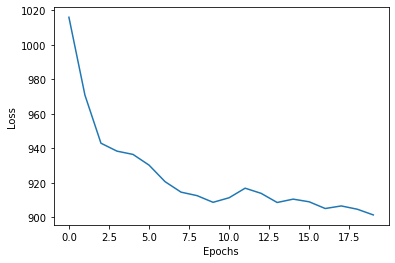

In [136]:
plt.ion() #Turn the interactive mode on
fig = plt.figure()
val_loss_avg = [1016,970.8,942.9,938.3, 936.4 , 930.2, 920.6,914.5, 912.478, 908.6, 911.25, 916.8,913.8,908.5, 910.45,908.9,905,906.5,904.6,901.290]
plt.plot(val_loss_sum)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [138]:
torch.save(model.state_dict(), "./model_checkpoints/gcn_batches.pth")

In [139]:
model.load_state_dict(torch.load('./model_checkpoints/gcn_batches.pth'))

GCN(
  (conv1): GCNLayer(
    (linear_self): Linear(in_features=4, out_features=32, bias=False)
    (linear): Linear(in_features=4, out_features=32, bias=True)
  )
  (conv2): GCNLayer(
    (linear_self): Linear(in_features=32, out_features=2, bias=False)
    (linear): Linear(in_features=32, out_features=2, bias=True)
  )
  (fc): Linear(in_features=2, out_features=2, bias=True)
)

In [133]:
batched_graph, output_masks,snorm_n, snorm_e= next(iter(train_dataloader))
print(output_masks.shape)
feats = batched_graph.ndata['x']
e_w = batched_graph.edata['w']
labels= batched_graph.ndata['gt']

pred = model(batched_graph, feats,e_w,snorm_n, snorm_e)
print(pred.shape, feats.shape, labels.shape)
pred = pred*output_masks #Con esto ya quito del error aquellas filas donde no tengo datos.
gt = labels*output_masks  #120 nodos outputmask V,T,C
x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) #B,V,T 
overall_sum_time = x2y2_error.sum(dim=-2)#BT - suma de los errores de los V agentes
overall_num = output_masks.sum(dim=-1).sum(dim=-2).type(torch.int) #torch.Tensor[(T)] - num de agentes en cada frame



torch.Size([350, 6, 1])
torch.Size([350, 6, 2]) torch.Size([350, 6, 4]) torch.Size([350, 6, 2])


In [84]:
i = next(iter(train_id_list))
graph = dgl.from_scipy(spp.coo_matrix(adj[0][:last_vis_obj[i],:last_vis_obj[i]])).int().to(dev)
snorm_n, snorm_e, norm_d = collate(graph)
distances = [xy_dist[0][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
norm_distances = [1/(i) if i!=0 else 1 for i in distances]
e_w= torch.tensor(norm_distances, dtype=torch.float32).to(dev)
print(e_w, graph)

tensor([1.0000, 0.1188, 1.0000, 0.1044, 0.1044, 1.0000, 0.1267, 0.1389, 1.0000,
        1.0000, 1.0000, 0.1115, 0.1021, 0.1314, 0.1238, 0.1188, 1.0000, 0.1115,
        1.0000, 0.1017, 0.3217, 0.1166, 0.1267, 1.0000, 0.6315, 0.1389, 0.1021,
        0.6315, 1.0000, 0.1017, 1.0000, 0.1314, 0.3217, 1.0000, 0.1725, 0.1238,
        0.1166, 0.1725, 1.0000], device='cuda:0') Graph(num_nodes=13, num_edges=39,
      ndata_schemes={}
      edata_schemes={})
